In [113]:
%%capture
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Initialization cell
import os
import subprocess

import pandas as pd
import numpy as np

path_to_NPDtools = '/home/letovesnoi/work/tools/NPDtools-2.4.0-Linux/'

data_dir = 'data'
gnps_library = os.path.join(data_dir, 'GNPS-LIBRARY.mgf')
# gnps_library = os.path.join(data_dir, 'tst.mgf')

spectra_dir = os.path.join(data_dir, 'spectra')
mols_dir = os.path.join(data_dir, 'mols')
fthr = os.path.join(data_dir, 'data.fthr')

reg_run_dir = os.path.join(data_dir, 'REG_RUN_GNPS')
fdr0_tsv = os.path.join(reg_run_dir, 'regrun_fdr0_complete.tsv')
spectra_rr_dir = os.path.join(data_dir, 'spectra_REG_RUN')
reg_run_df = pd.read_csv(fdr0_tsv, sep="\t")
grouped_df = reg_run_df.groupby(['SpecFile'])['LocalSpecIdx', 'Structure'].agg(list)
fthr_rr = os.path.join(data_dir, 'data_rr.fthr')

discrete_masses = np.linspace(0, 5000, num=50000, dtype='float64')

characteristics = []

In [2]:
# create directory for MGF files
if os.path.exists(spectra_dir):
    subprocess.call('rm -r {}'.format(spectra_dir), shell=True)
os.mkdir(spectra_dir)

# create directory for Molfiles
if os.path.exists(mols_dir):
    subprocess.call('rm -r {}'.format(mols_dir), shell=True)
os.mkdir(mols_dir)

In [3]:
def get_header(fin):
    header = []
    line = fin.readline()
    while '=' in line:
        ind = line.find('=')
        header.append((line[:ind], line[ind + 1:].strip()))
        line = fin.readline()
    return header, line

def get_spectrum(fin):
    header, line = get_header(fin)
    intensity = []
    while line != 'END IONS\n':
        intensity.append(line.strip().split())
        line = fin.readline()
    return header, np.array(intensity, dtype='float64')

def get_spectrum_id(header):
    return header[18][1]

def write_spectrum(header, intensity, spectrum_path):
    with open(spectrum_path, 'a') as fout:
        fout.write('BEGIN IONS\n')
        for key, value in header:
            fout.write(key + '=' + value + '\n')
        for mass, abundance in intensity:
            fout.write(str(mass) + ' ' + str(abundance) + '\n')
        fout.write('END IONS\n')

def split_mgf(mgf_library, out_dir, local_ids=None):
    spectra_pathes = []
    with open(mgf_library, 'r') as fin:
        num_spectra = 0
        while True:
            line = fin.readline()
            if not line:
                break
            header, intensity = get_spectrum(fin)
            num_spectra += 1
            if not local_ids:
                spectrum_id = get_spectrum_id(header)
            elif num_spectra - 1 in local_ids:
                mgf_name = os.path.splitext(os.path.basename(mgf_library))[0]
                spectrum_id = mgf_name + '_' + str(num_spectra - 1)
            else:
                continue
            spectra_pathes.append(os.path.join(out_dir, spectrum_id + '.mgf'))
            write_spectrum(header, intensity, spectra_pathes[-1])
    return spectra_pathes

def split_mgf_by_ids(mgf_library, spectra_dir, local_ids):
    spectra_pathes = []
    with open(mgf_library, 'r') as fin:
        num_spectra = 0
        while True:
            line = fin.readline()
            if not line:
                break
            header, intensity = get_spectrum(fin)
            if num_spectra in local_ids:
                mgf_name = os.path.splitext(os.path.basename(mgf_library))[0]
                spectra_pathes.append(os.path.join(spectra_dir, mgf_name + '_' + str(num_spectra) + '.mgf'))
                write_spectrum(header, intensity, spectra_pathes[-1])
            num_spectra += 1
    return spectra_pathes

In [4]:
peptidic = 0
smiles_errors = 0
known = 0
empty = 0

def get_smiles(header):
    return header[11][1]

def get_mol(spectrum_path):
    with open(spectrum_path, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        molfile = os.path.join(mols_dir, get_spectrum_id(header) + '.mol')
        # print('SMILES=' + get_smiles(header))
        # print('SPECTRUMID=' + get_spectrum_id(header))
        subprocess.call('molconvert mol:V3+H -s \'{}\' -o {}'.format(get_smiles(header), molfile), shell=True)
    return molfile

def is_structural(mgf_file):
    global known
    with open(mgf_file, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        if get_smiles(header) == 'N/A' or get_smiles(header) == '':
            return False
        else:
            known += 1
            return True

def is_peptidic(molfile):
    global smiles_errors, peptidic
    tmp_peptidic = os.path.join(data_dir, 'peptidic.tmp')
    subprocess.call('{0}bin/print_structure {1} -C {0}share/npdtools/ --print_rule_fragmented_graph > {2}'.format(path_to_NPDtools, molfile, tmp_peptidic), shell=True)
    with open(tmp_peptidic, 'r') as fin:
        line = fin.readline()
        subprocess.call('rm {}'.format(tmp_peptidic), shell=True)
        if 'number of components' in line:
            num_components = line.strip().split(':')[1][1:]
        else:
            smiles_errors += 1
            print('{} contains an error'.format(molfile))
            return -1
    if int(num_components) > 3:
        peptidic += 1
        return 1
    else:
        return 0

def is_empty(mgf_file):
    global empty
    with open(mgf_file, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)
        if len(intensity) != 0:
            return False
        else:
            empty += 1
            print('{} has no information about intensity'.format(mgf_file))
            return True
        
def filter_spectra():
    for mgf_file in tqdm(split_mgf(gnps_library, spectra_dir)):
        # remove unknown spectrum
        if not is_structural(mgf_file) or is_empty(mgf_file):
            subprocess.call('rm {}'.format(mgf_file), shell=True)
        else:
            molfile = get_mol(mgf_file)
            # remove non-peptidic data
            is_pep = is_peptidic(molfile)
            if is_pep == 0 or is_pep == -1:
                subprocess.call('rm {}'.format(mgf_file), shell=True)
                subprocess.call('rm {}'.format(molfile), shell=True)
                
filter_spectra()

print('{} have a known structure'.format(known))
print('{} have no information about intensity'.format(empty))
print('{} SMILES contains an error'.format(smiles_errors))
print('{} peptidic among structural, with non zero intensity, and with correct SMILES'.format(peptidic))

data/spectra/CCMSLIB00000078897.mgf has no information about intensity
data/mols/CCMSLIB00000478055.mol contains an error
data/mols/CCMSLIB00000478057.mol contains an error
data/mols/CCMSLIB00000478082.mol contains an error
data/mols/CCMSLIB00000478089.mol contains an error
data/mols/CCMSLIB00000478097.mol contains an error
data/mols/CCMSLIB00000478103.mol contains an error
data/spectra/CCMSLIB00000577483.mgf has no information about intensity
data/spectra/CCMSLIB00000577484.mgf has no information about intensity
data/spectra/CCMSLIB00000577485.mgf has no information about intensity
data/spectra/CCMSLIB00004722219.mgf has no information about intensity
data/mols/CCMSLIB00005435738.mol contains an error
data/mols/CCMSLIB00005436087.mol contains an error

2247 have a known structure
5 have no information about intensity
8 SMILES contains an error
443 peptidic among structural, with non zero intensity, and with correct SMILES


In [5]:
def get_fthr(spectra_pathes, fthr, discrete_masses):
    spectra_df = pd.DataFrame()
    for mgf_file in tqdm(spectra_pathes):
        with open(mgf_file, 'r') as fin:
            fin.readline()
            header, intensity = get_spectrum(fin)
        id = os.path.splitext(os.path.basename(mgf_file))[0]
        bins = pd.cut(intensity[:, 0], bins=discrete_masses, labels=False)
        spectrum_df = pd.DataFrame({id: intensity[:, 1], 'binned': bins}).groupby(['binned']).sum().T
        spectra_df = pd.concat([spectra_df, spectrum_df], sort=True)
    spectra_df.columns = spectra_df.columns.astype(str)
    spectra_df.reset_index().to_feather(fthr)
    return fthr

spectra_pathes = [os.path.join(spectra_dir, sp) for sp in os.listdir(spectra_dir)]

fthr = get_fthr(spectra_pathes, fthr, discrete_masses)

In [6]:
# create directory for MGF files
if os.path.exists(spectra_rr_dir):
    subprocess.call('rm -r {}'.format(spectra_rr_dir), shell=True)
os.mkdir(spectra_rr_dir)

spectra_rr_pathes = []
for index, row in grouped_df.iterrows():
    mgf_path = os.path.join(reg_run_dir, os.path.splitext(index)[0] + '_filtered.mgf')
    spectra_rr_pathes.extend(split_mgf(mgf_path, spectra_rr_dir, row['LocalSpecIdx']))

fthr_rr = get_fthr(spectra_rr_pathes, fthr_rr, discrete_masses)

In [24]:
# Skip other cells except initialization and run this
def get_df_from_files(fthr,  fthr_rr):
    spectra_df = pd.read_feather(fthr)
    del spectra_df['index']
    spectra_df.columns = pd.to_numeric(spectra_df.columns)

    spectra_rr_df = pd.read_feather(fthr_rr)
    del spectra_rr_df['index']
    spectra_rr_df.columns = pd.to_numeric(spectra_rr_df.columns)

    df = pd.concat([spectra_df, spectra_rr_df], sort=True)
    
    df = df.fillna(0)
    
    display(df)
    
    return df

df = get_df_from_files(fthr,  fthr_rr)

,344,404,424,440,445,449,450,451,452,453,...,30006,30014,30015,30017,30018,30025,30030,30033,30046,30047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


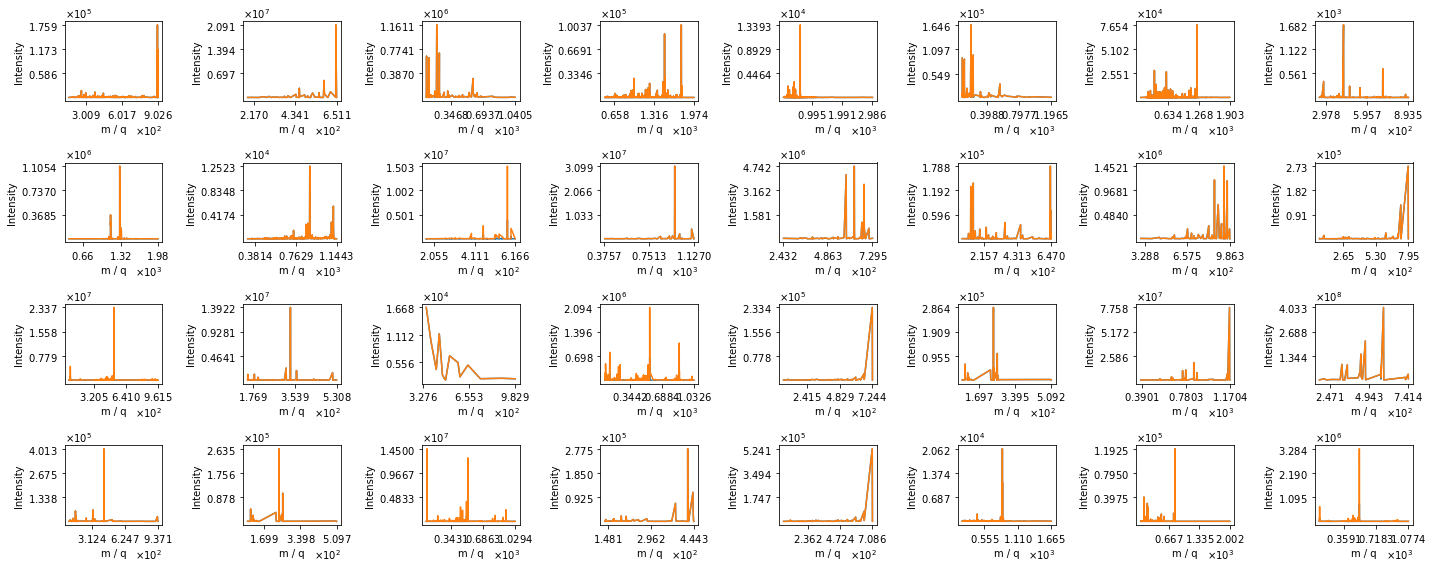

Discretization: 100



,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.000000,0.000000,7.084000e+03,2.264800e+04,50748.000000,21100.000000,5.223600e+04,4.254400e+04,2.692800e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,1.838925e+05,1.717363e+05,820616.277344,641320.910156,1.235266e+06,1.210168e+06,4.994318e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,870677.520507,931872.419434,1.822306e+06,1.008206e+06,118204.316405,243420.150880,7.661343e+04,9.089011e+04,8.177134e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,9.005057e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,660.000000,1325.000000,6.039000e+03,5.497000e+03,4251.000000,2491.000000,1.350800e+04,8.053000e+03,4.351000e+03,...,48.0,0.0,28.0,0.0,0.0,0.0,0.0,12.0,31.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,3.290906,16.332643,7.064710e+01,6.037970e+01,44.743547,80.543028,8.764721e+01,1.867168e+01,9.947589e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,2.550336,21.087722,7.371103e+01,7.462950e+01,27.375205,126.681225,6.729701e+01,4.537154e+01,6.062993e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,3.356076,18.472262,7.791265e+01,5.986797e+01,41.288044,70.729847,1.124424e+02,4.798482e+01,7.414129e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,1.858777,18.592175,7.528047e+01,7.285349e+01,43.868458,129.374403,3.731649e+01,2.664174e+01,9.809894e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


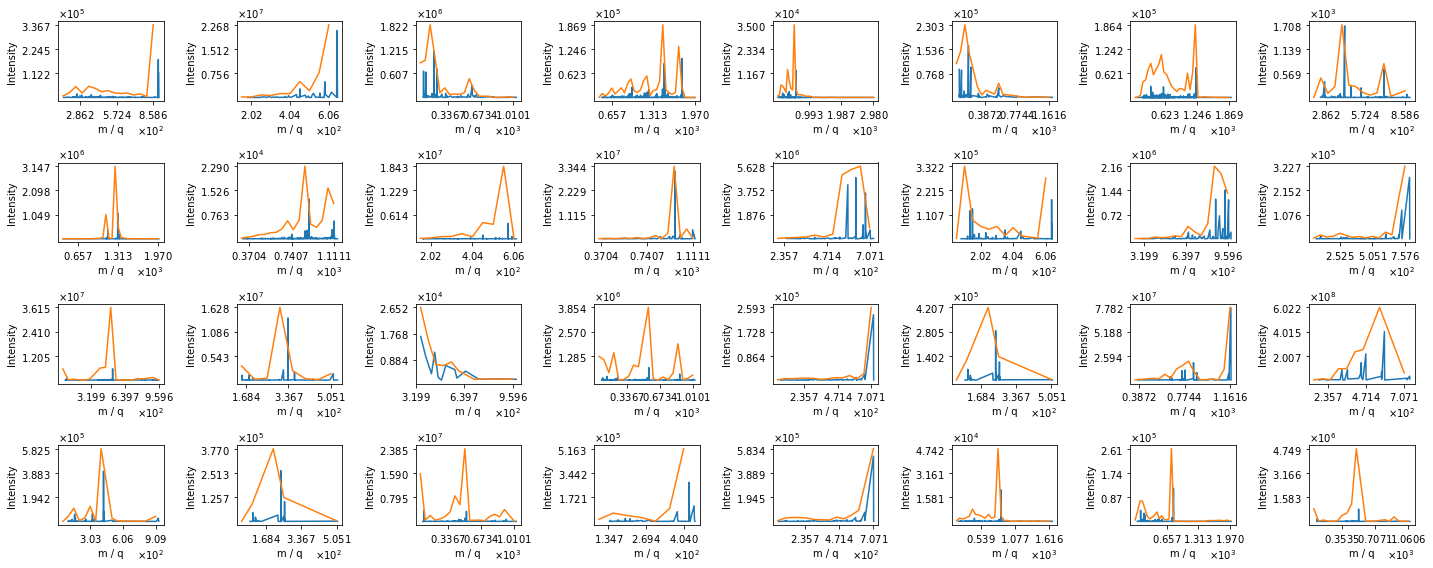

Discretization: 500



,3,4,5,6,7,8,9,10,11,12,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,803794.493652,66883.026855,31190.272461,767564.056641,102149.684082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,21.0,45.0,15.0,343.000000,236.000000,107.000000,273.000000,111.000000,...,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,2.240370,1.050536,9.675379,0.000000,4.387874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,2.550336,0.000000,11.180899,2.668144,4.568352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,2.420928,0.935149,10.098990,0.000000,3.762128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,1.858777,0.000000,10.919214,1.431523,3.953205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


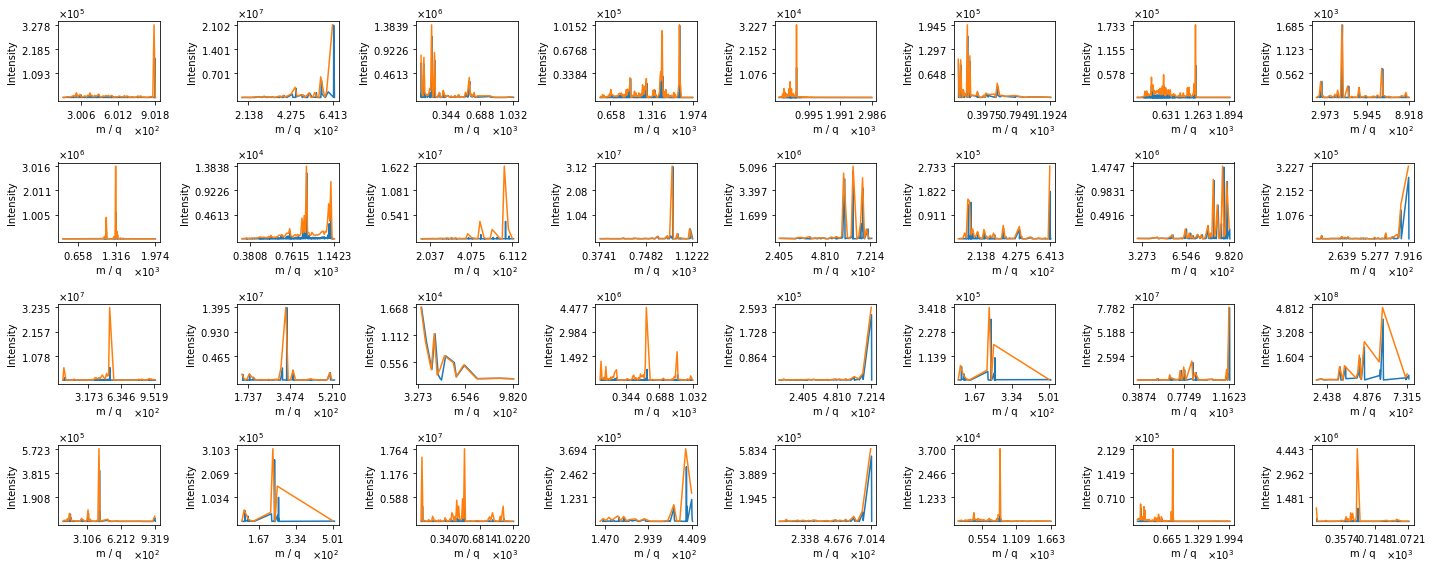

Discretization: 1000



,6,8,9,10,11,12,13,14,15,16,...,591,592,593,594,595,596,597,598,599,600
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,709421.884277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,21.0,0.0,0.0,6.0,47.0,7.0,151.000000,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.359852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


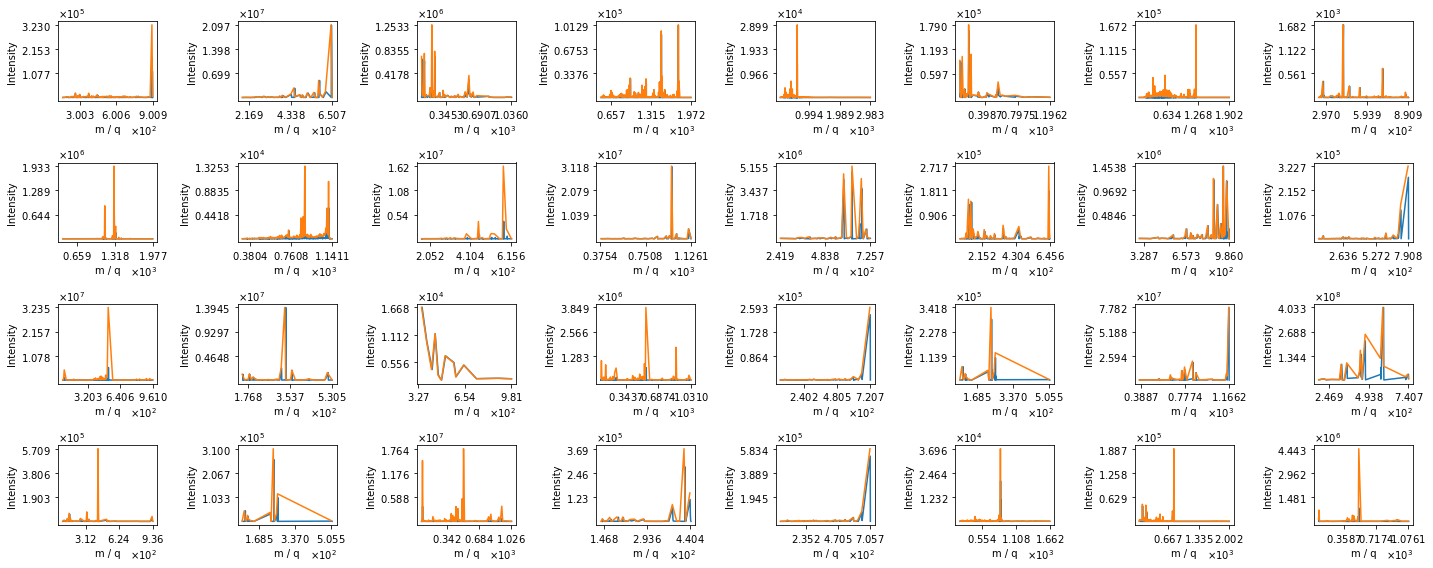

Discretization: 5000



,34,40,42,44,45,46,47,48,49,50,...,2994,2995,2996,2997,2998,2999,3000,3001,3002,3004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


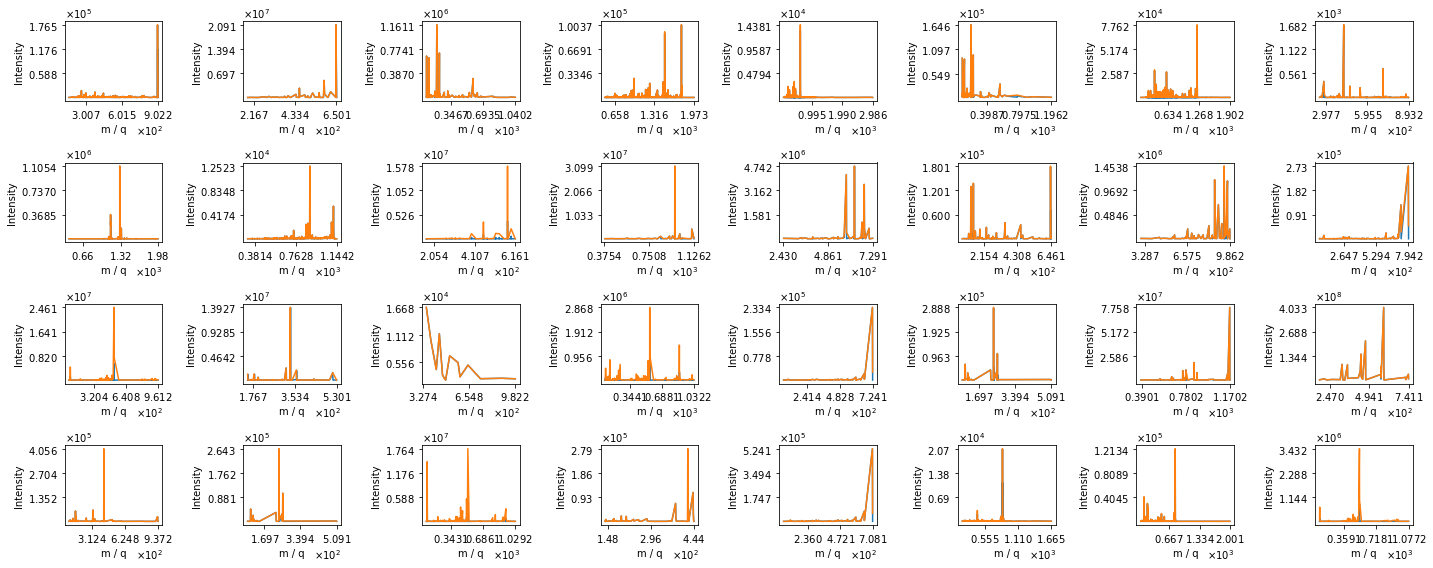

Discretization: 10000



,68,80,84,88,89,90,91,92,93,94,...,5997,5998,5999,6000,6002,6003,6004,6005,6006,6008
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


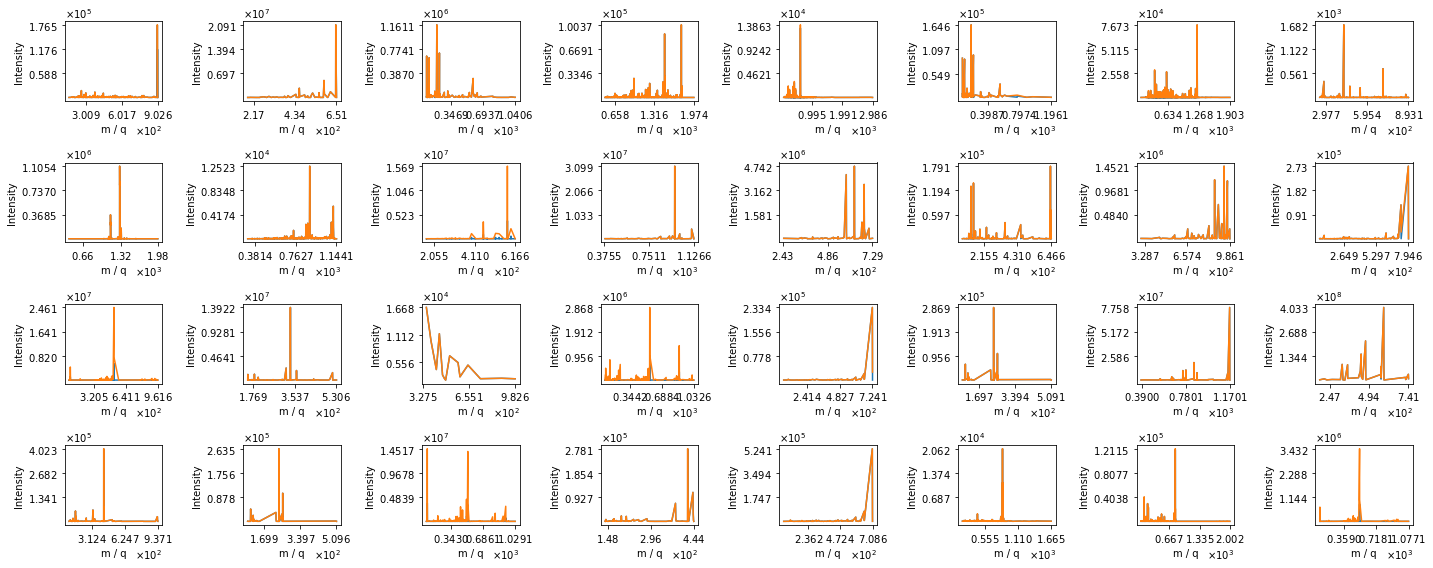

In [95]:
# Skip it!  
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Test discretisation
def plot_discretisation(tst_d_m=discrete_masses):
    i = 0
    fig = plt.figure(figsize=(20, 8))
#     fig.text(0.5, 0.04, 'Mass-to-charge ratio', ha='center', va='center')
#     fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical')
    for mgf_file in tqdm(spectra_pathes):
        if i == 32:
            break
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        with open(mgf_file, 'r') as fin:
            fin.readline()
            header, intensity = get_spectrum(fin)
        id = os.path.splitext(os.path.basename(mgf_file))[0]
        ax.plot(intensity[:, 0], intensity[:, 1])
        bins = pd.cut(intensity[:, 0], bins=tst_d_m, labels=False)
        tst_df = pd.DataFrame({'intensity': intensity[:, 1], 'binned': bins}).groupby(['binned'], as_index=False).sum()
        tst_df['x'] = tst_df['binned'].transform(lambda b: tst_d_m[b])
        ax.plot(tst_df.x, tst_df.intensity)
#         ax.grid(True)
        ax.set_xlabel('m / q')
        ax.set_ylabel('Intensity')
        ax.set_xticks(np.arange(max(tst_df.x) / 3, max(tst_df.x) * 7 / 6, max(tst_df.x) / 3))
        ax.set_yticks(np.arange(max(tst_df.intensity) / 3, max(tst_df.intensity) * 7 / 6, max(tst_df.intensity) / 3))
        ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0), useMathText=True)        
        i += 1
    fig.tight_layout()
    return ax
        
plt.show(plot_discretisation())

# Try different discretizations:
discr_list = [100, 500, 1000, 5000, 10000]
fthr_list = []
fthr_rr_list = []
df_list = []
for discr_n in discr_list:
    print('Discretization: {}\n'.format(discr_n))
    discr_m = np.linspace(0, 5000, num=discr_n, dtype='float64')
    
    fthr_d = os.path.join(data_dir, 'data.' + str(discr_n) + '.fthr')
    fthr_list.append(get_fthr(spectra_pathes, fthr_d, discr_m))
    
    fthr_rr_d = os.path.join(data_dir, 'data_rr.' + str(discr_n) + '.fthr')
    fthr_rr_list.append(get_fthr(spectra_rr_pathes, fthr_rr_d, discr_m))
    
    df_list.append(get_df_from_files(fthr_d,  fthr_rr_d))
    
    plt.show(plot_discretisation(discr_m))

In [112]:
# Calculate number of peaks in input spectra
peaks_set = set()
for mgf_file in tqdm(spectra_pathes + spectra_rr_pathes):
    with open(mgf_file, 'r') as fin:
        fin.readline()
        header, intensity = get_spectrum(fin)        
        peaks_set.update(intensity[:, 0])
print('There are {} peaks at all'.format(len(peaks_set)))


There are 783055 peaks at all


In [96]:
# Get labels
def get_spectrum_cyclicality(molfile):
    tmp_cyclicality = os.path.join(data_dir, 'cyclicality.tmp')
    subprocess.call('{0}bin/print_structure {1} -C {0}share/npdtools/ --print_structure > {2}'.format(path_to_NPDtools, molfile, tmp_cyclicality), shell=True)
    with open(tmp_cyclicality, 'r') as fin:
        cyclicality = fin.readline().strip()
    subprocess.call('rm {}'.format(tmp_cyclicality), shell=True)
    return cyclicality

cycl_dict = {'linear': 0, 'cyclic': 1, 'b-cyclic': 2, 'branch-cyclic': 2, 'complex': 3}

def get_labels(mols_dir):
    labels = []
    for molfile in tqdm(os.listdir(mols_dir)):
        cyclicality = get_spectrum_cyclicality(os.path.join(mols_dir, molfile))
        labels.append(cycl_dict[cyclicality])
    return labels    

def get_labels_rr(grouped_df):
    labels = []
    for index, row in grouped_df.iterrows():
        labels.extend([cycl_dict[cyclicality] for cyclicality in row['Structure']])
    return labels

labels = get_labels(mols_dir) + get_labels_rr(grouped_df)

print('{} linear'.format(labels.count(0)))
print('{} cyclic'.format(labels.count(1)))
print('{} branch-cyclic'.format(labels.count(2)))
print('{} complex'.format(labels.count(3)))


3186 linear
2763 cyclic
1763 branch-cyclic
236 complex


In [97]:
# Remove complex and branch-cyclic classes
nl = np.array(labels)
criteria = np.logical_or(nl == 0, nl == 1) 
l_2 = nl[criteria]
df_list_2 = [dataframe[criteria] for dataframe in df_list]
df_2 = df[criteria]

In [187]:
import keras
from sklearn.model_selection import train_test_split

choosen_df = df_list_2[4]

X = choosen_df.to_numpy().astype('float32')
y = np.array(l_2).astype('float32')

display(choosen_df)

X_train, X_test, train_binary_labels, test_binary_labels = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# one-hot encode the labels
num_classes = len(np.unique(train_binary_labels))
y_train = keras.utils.to_categorical(train_binary_labels, num_classes)
y_test = keras.utils.to_categorical(test_binary_labels, num_classes)

print(X_train_3d.shape)

,68,80,84,88,89,90,91,92,93,94,...,5997,5998,5999,6000,6002,6003,6004,6005,6006,6008
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(4759, 5572, 1)


In [188]:
# Benchmark model
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42).fit(X_train, y_train)

In [190]:
# Try clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score

for dataframe in df_list_2:
    kmeans_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X)
    unique, counts = np.unique(kmeans_pred, return_counts=True)
    print('Kmeans predictions:', dict(zip(unique, counts)))

#     gmm_pred = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit_predict(X)
#     unique, counts = np.unique(gmm_pred, return_counts=True)
#     print('GMM predictions:', dict(zip(unique, counts)))

Kmeans predictions: {0: 5948, 1: 1}
Kmeans predictions: {0: 5948, 1: 1}
Kmeans predictions: {0: 5948, 1: 1}
Kmeans predictions: {0: 5948, 1: 1}
Kmeans predictions: {0: 5948, 1: 1}


In [191]:
# Try SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# C, kernel, degree, gamma
# parameters = {'kernel': ['poly', 'rbf'], 'gamma': [4, 16, 32], 'degree': [2, 4]}
# svc = SVC(class_weight='balanced')
# svc_clf = GridSearchCV(svc, parameters, cv=5, scoring=make_scorer('roc_auc'))
svc_clf = SVC(class_weight='balanced')
svc_clf.fit(X_train, train_binary_labels)
# print(svc_clf.best_estimator_)

/home/letovesnoi/tools/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [192]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_clf = Sequential()
# model.add(Conv2D(filters=4, kernel_size=4, padding='same', activation='relu', input_shape=(1, 23325, 1)))
# model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Conv2D(filters=4, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(1,2)))
cnn_clf.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu', 
                   input_shape=(X_train_3d.shape[1], 1)))
cnn_clf.add(MaxPooling1D(pool_size=2))
cnn_clf.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
cnn_clf.add(MaxPooling1D(pool_size=2))
cnn_clf.add(Dropout(0.3))
cnn_clf.add(Flatten())
cnn_clf.add(Dense(64, activation='relu'))
cnn_clf.add(Dropout(0.4))
cnn_clf.add(Dense(num_classes, activation='softmax'))
cnn_clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 5572, 64)          320       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 2786, 64)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2786, 64)          16448     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1393, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1393, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 89152)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                5705792   
__________

In [193]:
# compile the model
cnn_clf.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [194]:
# train the model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
w = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(train_binary_labels), train_binary_labels)))
print('class weight = ', w, '\n')
hist = cnn_clf.fit(X_train_3d, y_train, batch_size=32, epochs=25, validation_split=0.2, 
                 callbacks=[checkpointer], verbose=2, shuffle=True, class_weight=w)

class weight =  {0: 0.9338697017268446, 1: 1.0762098597919494} 

Train on 3807 samples, validate on 952 samples
Epoch 1/25
 - 135s - loss: 0.2914 - acc: 0.9643 - val_loss: 0.1415 - val_acc: 0.9874

Epoch 00001: val_loss improved from inf to 0.14154, saving model to model.weights.best.hdf5
Epoch 2/25
 - 117s - loss: 0.2527 - acc: 0.9790 - val_loss: 0.1307 - val_acc: 0.9863

Epoch 00002: val_loss improved from 0.14154 to 0.13066, saving model to model.weights.best.hdf5
Epoch 3/25
 - 115s - loss: 0.2309 - acc: 0.9821 - val_loss: 0.1317 - val_acc: 0.9874

Epoch 00003: val_loss did not improve from 0.13066
Epoch 4/25
 - 119s - loss: 0.2339 - acc: 0.9819 - val_loss: 0.1326 - val_acc: 0.9905

Epoch 00004: val_loss did not improve from 0.13066
Epoch 5/25
 - 119s - loss: 0.2234 - acc: 0.9837 - val_loss: 0.1385 - val_acc: 0.9895

Epoch 00005: val_loss did not improve from 0.13066
Epoch 6/25
 - 121s - loss: 0.2299 - acc: 0.9837 - val_loss: 0.1113 - val_acc: 0.9926

Epoch 00006: val_loss improved 

In [195]:
# load the weights that yielded the best validation accuracy
cnn_clf.load_weights('model.weights.best.hdf5')

DummyClassifier TN = 638, DummyClassifier FP = 0, DummyClassifier FN = 552, DummyClassifier TP = 0
Sequential TN = 614, Sequential FP = 24, Sequential FN = 9, Sequential TP = 543
SVC TN = 598, SVC FP = 40, SVC FN = 0, SVC TP = 552


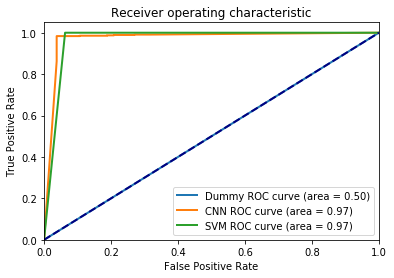

In [196]:
# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

def evaluate_imbalanced(clf):
    type_clf = type(clf).__name__
    if type_clf == 'Sequential':
        x = X_test_3d
    else:
        x = X_test
    y_pred = clf.predict(x)
    if type_clf != 'SVC':
        pred_binary_labels = np.argmax(y_pred, axis=1)
        y_score = y_pred[:, 1]
    else:
        pred_binary_labels = y_pred
        y_score = y_pred
    tn, fp, fn, tp = confusion_matrix(test_binary_labels, pred_binary_labels).ravel()
    print('{name} TN = {tn}, {name} FP = {fp}, {name} FN = {fn}, {name} TP = {tp}'.
          format(tn=tn, fp=fp, fn=fn, tp=tp, name=type_clf))
    fpr, tpr, thresholds = roc_curve(test_binary_labels, y_score)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


fpr_d, tpr_d, auc_d = evaluate_imbalanced(dummy_clf)
fpr_cnn, tpr_cnn, auc_cnn = evaluate_imbalanced(cnn_clf)
fpr_svc, tpr_svc, auc_svc = evaluate_imbalanced(svc_clf)

# characteristics.append([[fpr_d, tpr_d, auc_d], [fpr_cnn, tpr_cnn, auc_cnn], [fpr_svc, tpr_svc, auc_svc]])

# Plot ROC curves for these two models
plt.figure()
plt.plot(fpr_d, tpr_d, lw=2, label='Dummy ROC curve (area = %0.2f)' % auc_d)
plt.plot(fpr_cnn, tpr_cnn, lw=2, label='CNN ROC curve (area = %0.2f)' % auc_cnn)
plt.plot(fpr_svc, tpr_svc, lw=2, label='SVM ROC curve (area = %0.2f)' % auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

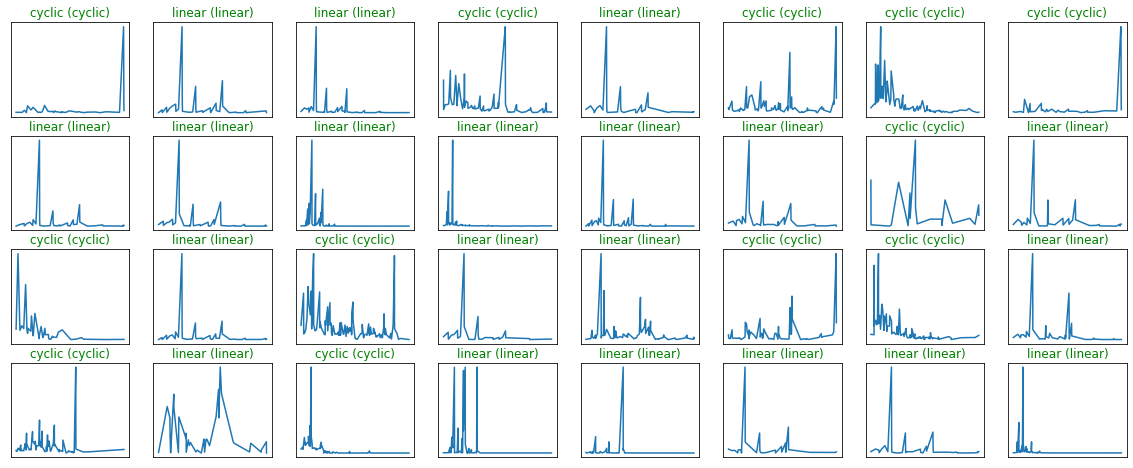

In [200]:
# Visualize some predictions
import matplotlib.pyplot as plt

# define text labels
names = ['linear', 'cyclic', 'b-cyclic', 'complex']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
y_cnn = cnn_clf.predict(X_test_3d)
for i, rc_i in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])    
    x = np.array([discrete_masses[int(bin_i)] for bin_i in choosen_df.columns.values.tolist()])
    y = np.array(X_test[rc_i])  
    y_mask = (y != 0)
    ax.plot(x[y_mask], y[y_mask])
    pred_idx = np.argmax(y_cnn[rc_i])
    true_idx = int(test_binary_labels[rc_i])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]), 
                 color=("green" if pred_idx == true_idx else "red"))

Discretization 100:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.96)
SVM ROC curve (area = 0.81)

Discretization 500:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.97)
SVM ROC curve (area = 0.88)

Discretization 1000:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.96)
SVM ROC curve (area = 0.92)

Discretization 5000:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.98)
SVM ROC curve (area = 0.96)

Discretization 10000:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.97)
SVM ROC curve (area = 0.97)

Discretization 50000:
Dummy ROC curve (area = 0.50)
CNN ROC curve (area = 0.98)
SVM ROC curve (area = 0.98)



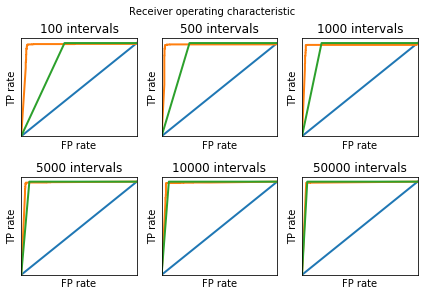

In [205]:
# [[[fpr_d, tpr_d, auc_d], [fpr_cnn, tpr_cnn, auc_cnn], [fpr_svc, tpr_svc, auc_svc]], ... , [[...], [...], [...]]]
# fig = plt.figure(figsize=(20, 8))
fig = plt.figure()
fig.text(0.5, 1, 'Receiver operating characteristic', ha='center', va='center')
all_discr_list = [100, 500, 1000, 5000, 10000, 50000]
for i, c in enumerate(characteristics):
    c_dummy, c_cnn, c_svc = c
    fpr_d, tpr_d, auc_d = c_dummy
    fpr_cnn, tpr_cnn, auc_cnn = c_cnn
    fpr_svc, tpr_svc, auc_svc = c_svc
    
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.plot(fpr_d, tpr_d, lw=2)
    ax.plot(fpr_cnn, tpr_cnn, lw=2)
    ax.plot(fpr_svc, tpr_svc, lw=2)
    print('Discretization {}:'.format(all_discr_list[i]))
    print('Dummy ROC curve (area = %0.2f)' % auc_d)
    print('CNN ROC curve (area = %0.2f)' % auc_cnn)
    print('SVM ROC curve (area = %0.2f)\n' % auc_svc)
#     ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('{} intervals'.format(all_discr_list[i]))
#     ax.legend()
    fig.tight_layout()